In [1]:
import numpy as np
import pandas as pd 

import seaborn as sns 
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
plt.style.use(['fivethirtyeight', 'dark_background'])

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D

!pip install pyemma
from pyemma import msm
%matplotlib inline

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - \ done
     |████████████████████████████████| 911kB 26.1MB/s 
     |████████████████████████████████| 327kB 19.7MB/s 
  Created wheel for pyemma: filename=pyEMMA-2.5.6-cp36-cp36m-linux_x86_64.whl size=2606576 sha256=244610c6b05cfb786f4e435e879109d66cc14ae55f01992eb62c4f9eed6950c7
  Stored in directory: /tmp/.cache/pip/wheels/23/f5/39/c7368c3c84952043c6dcc605b981a1caf5414380f8b734c32a
Successfully built pyemma
  Created wheel for msmtools: filename=msmtools-1.2.4-cp36-cp36m-linux_x86_64.whl size=2223716 sha256=4e95a44bbd83deeab3fc1b2be216764dacfe5f714f8c914f079a08c6e547ad88
  Stored in directory: /tmp/.cache/pip/wheels/51/96/3d/d021a73aa2d044dd39110b7b3069c23ebd044175bb2d2a7140
  Created wheel for bhmm: filename=bhmm-0.6.3-cp36-cp36

In [2]:
train = pd.read_csv('/kaggle/input/expedia-personalized-sort/data/train.csv')

In [3]:
train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [4]:
train.isnull().sum()

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        9412233
visitor_hist_adr_usd           9409918
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                14630
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           2178380
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      9281966
orig_destination_distance

# Subset data
Select property / visitor location country / srch_room_count with the most data points 

In [5]:
# prop_id corresponding to 
train['prop_id'].value_counts()

104517    4733
124342    4707
68420     4580
134154    4550
40279     4535
          ... 
69676        1
72761        1
48140        1
8565         1
127084       1
Name: prop_id, Length: 136886, dtype: int64

In [6]:
train['visitor_location_country_id'].value_counts()

219    5778805
100     990487
55      580072
216     434568
220     350433
        ...   
54          31
198         30
146         30
24          29
8           27
Name: visitor_location_country_id, Length: 218, dtype: int64

In [7]:
# Num of rooms specified in search by customer
train['srch_room_count'].value_counts()

1    9045780
2     734315
3      92372
4      25023
5       8053
8       4950
6       4345
7       2692
Name: srch_room_count, dtype: int64

In [8]:
# Subset df 
df = train.loc[train['prop_id'] == 104517]

df = df.loc[df['visitor_location_country_id'] == 219]

df = df.loc[df['srch_room_count'] == 1]

# srch_saturday = if stay includes Sat night 
# srch_booking_window = num of days between search date and hotel stay start date 
df = df[['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049 entries, 2041 to 9917395
Data columns (total 4 columns):
date_time                   3049 non-null object
price_usd                   3049 non-null float64
srch_booking_window         3049 non-null int64
srch_saturday_night_bool    3049 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 119.1+ KB


In [10]:
df.describe()

,price_usd,srch_booking_window,srch_saturday_night_bool
count,3049.000000,3049.000000,3049.000000
mean,112.939023,37.082650,0.524434
std,113.374049,46.160272,0.499485
min,0.120000,0.000000,0.000000
25%,67.000000,6.000000,0.000000
50%,100.000000,20.000000,1.000000
75%,141.000000,48.000000,1.000000
max,5584.000000,292.000000,1.000000


Point anomaly = max price usd 5584

In [11]:
train.loc[(train['price_usd'] == 5584) & 
         (train['visitor_location_country_id'] == 219)]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
2905344,195154,2013-04-07 20:59:07,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,28.0,0,NaN,0


Possible wrong search, no intention to book

In [12]:
# Remove 5584 
df = df.loc[df['price_usd'] < 5584]
df['price_usd'].describe()

count    3048.000000
mean      111.144055
std        55.055161
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max       536.000000
Name: price_usd, dtype: float64

In [13]:
df['date_time'].min(), df['date_time'].max()

('2012-11-01 02:48:30', '2013-06-30 22:50:21')

In [14]:
df['date_time'].describe()

df['date_time'] = pd.to_datetime(df['date_time'])

df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
2041,2013-03-14 11:27:28,206.0,99,1
3152,2013-01-03 20:48:24,186.0,6,0
5166,2013-01-19 16:51:27,61.0,1,0
10135,2013-01-26 11:34:23,72.0,116,0
10560,2013-04-29 09:39:50,246.0,245,0


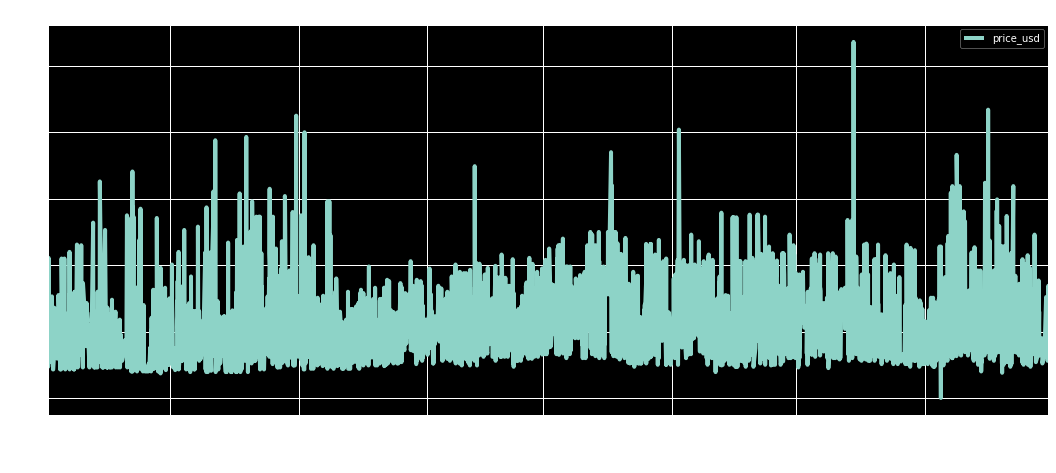

In [15]:
df.plot(x = 'date_time', 
        y = 'price_usd', 
        figsize = (16, 8))

plt.xlabel('dates')
plt.ylabel('USD')
plt.title('Time series of room price by date of search');

In [16]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
2041,2013-03-14 11:27:28,206.0,99,1
3152,2013-01-03 20:48:24,186.0,6,0
5166,2013-01-19 16:51:27,61.0,1,0
10135,2013-01-26 11:34:23,72.0,116,0
10560,2013-04-29 09:39:50,246.0,245,0


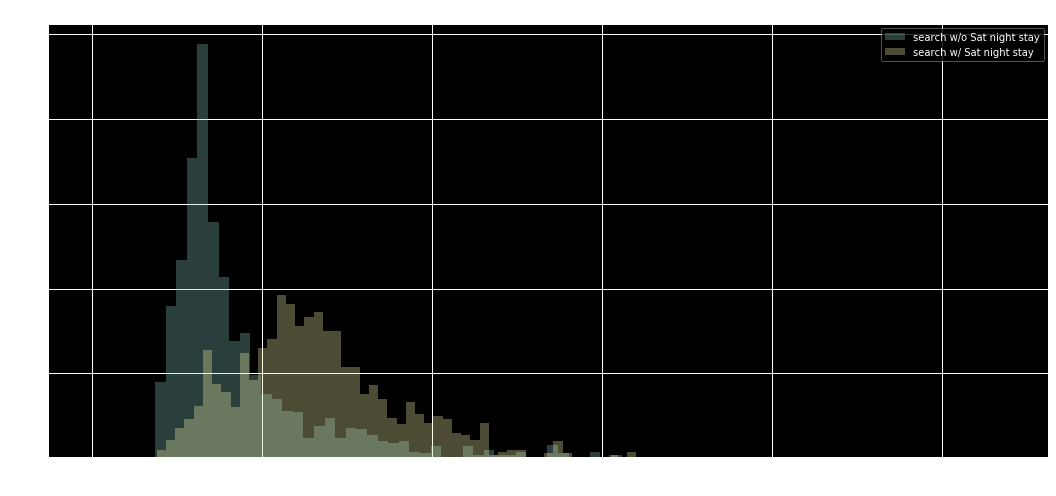

In [17]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

plt.figure(figsize = (16, 8))

plt.hist(a, bins = 80, 
         alpha = 0.3, 
         label = 'search w/o Sat night stay')

plt.hist(b, bins = 80, 
         alpha = 0.3, 
         label = 'search w/ Sat night stay')

plt.xlabel('Price')
plt.ylabel('Freq')
plt.legend()
plt.title('Sat night search')
plt.plot();

In [18]:
df['srch_saturday_night_bool'].value_counts()

1    1599
0    1449
Name: srch_saturday_night_bool, dtype: int64

In [19]:
print('Kurtosis: %f' % df['price_usd'].kurt())
print('Skewness: %f' % df['price_usd'].skew())

Kurtosis: 3.617559
Skewness: 1.443641


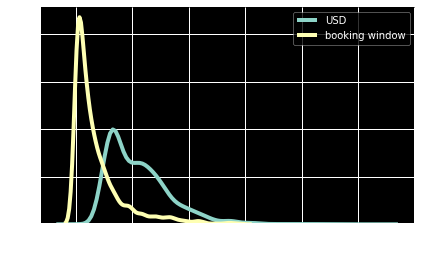

In [20]:
sns.distplot(df['price_usd'], 
                 hist = False, label = 'USD')

sns.distplot(df['srch_booking_window'], 
                  hist = False, label = 'booking window')

plt.xlabel('dist')
sns.despine()

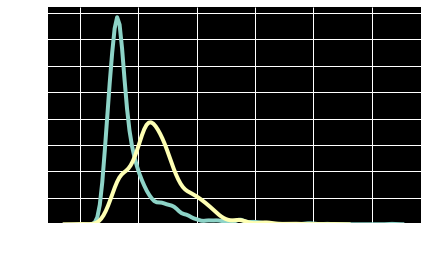

In [21]:
sns.distplot(a, hist = False, rug = False)
sns.distplot(b, hist = False, rug = False)

sns.despine()

In [22]:
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)

# Cluster-based models

- k-means
- isolation forest
- clustering

Potential outliers:
- usd
- srch_booking_window (days between search and first stay date)
- srch_saturday (stay includes sat night

# K-means

- create 'k' similar clusters of instances  
- Instances outside of clusters = possible anomalies 

In [23]:
# Determine optimal cluster num using elbow method 
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)

kmeans = [KMeans(n_clusters = i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

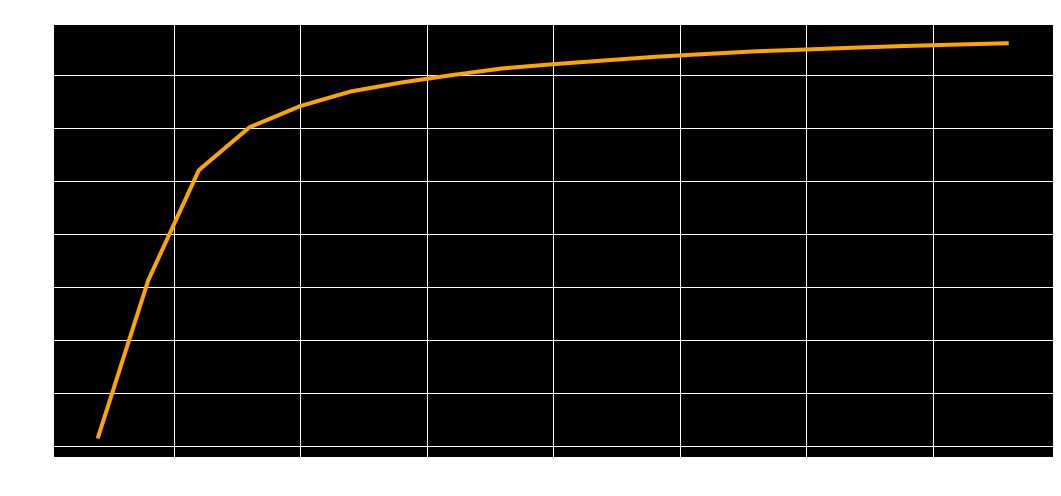

In [24]:
# elbow curve 
fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(n_cluster, scores, color = 'orange')

plt.xlabel('clusters num')
plt.ylabel('score')
plt.title('elbow curve')
plt.show();

set n_clusters to 7

n_clusters > 7 = additional clusters do not explain greater variance in variable 

where variable = price_usd

In [25]:
# k means output 
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop = True)

km = KMeans(n_clusters = 7)
km.fit(X)
km.predict(X)

labels = km.labels_

X.head()

,price_usd,srch_booking_window,srch_saturday_night_bool
0,84.0,19,0
1,78.0,16,1
2,114.0,56,1
3,76.0,56,1
4,128.0,0,1


# 3D clusters 
plot using k means output 

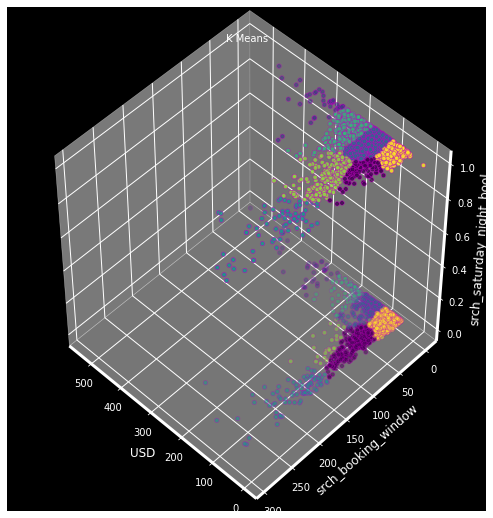

In [26]:
fig = plt.figure(1, figsize = (7, 7))

ax = Axes3D(fig, rect = [0, 0, 0.95, 1], 
            elev = 48, azim = 134)

ax.scatter(X.iloc[:, 0], 
           X.iloc[:, 1], 
           X.iloc[:, 2],
           c = labels.astype(np.float), edgecolor = 'm')

ax.set_xlabel('USD')
ax.set_ylabel('srch_booking_window')
ax.set_zlabel('srch_saturday_night_bool')

plt.title('K Means', fontsize = 10);

In [27]:
import pylab as pl 

# PCA 

In [28]:
#Y = df[['price_usd']]
#X = df[['srch_booking_window']]

#Nc = range(1, 20)
#kmeans = [KMeans(n_clusters = i) for i in Nc]

#score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

#plt.figure(figsize = (16, 8))
#pl.plot(Nc, score)
#pl.xlabel('cluster num')
#pl.ylabel('score')
#pl.title('elbow curve')
#pl.show();

In [29]:
#pca = PCA(n_components = 1).fit(Y)

#pca_d = pca.transform(Y)
#pca_c = pca.transform(X)

#kmeans = KMeans(n_clusters = 7)
#kmeansoutput = kmeans.fit(Y)

#pl.figure('7 cluster k-means')
#pl.figure(figsize = (16, 8))

#pl.scatter(pca_c[:, 0], 
#           pca_d[:, 0], 
#           c = kmeansoutput.labels_)

#pl.xlabel('booking window')
#pl.ylabel('USD')
#pl.title('7 cluster')
#pl.show();

In [30]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

X = data.values
X_std = StandardScaler().fit_transform(X)

# Calc eigenvec cor & eig_vals of covar matrix 
mean_vec = np.mean(X_std, axis = 0)

cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# eig_val,eig_vecs tuple
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse = True)

In [31]:
# Calc explained var from eig_vals 
total = sum(eig_vals)

# Individual explained var 
var_exp = [(i/total)*100 for i in sorted(eig_vals, reverse = True)]

# Cumulative explained var 
cum_var_exp = np.cumsum(var_exp)

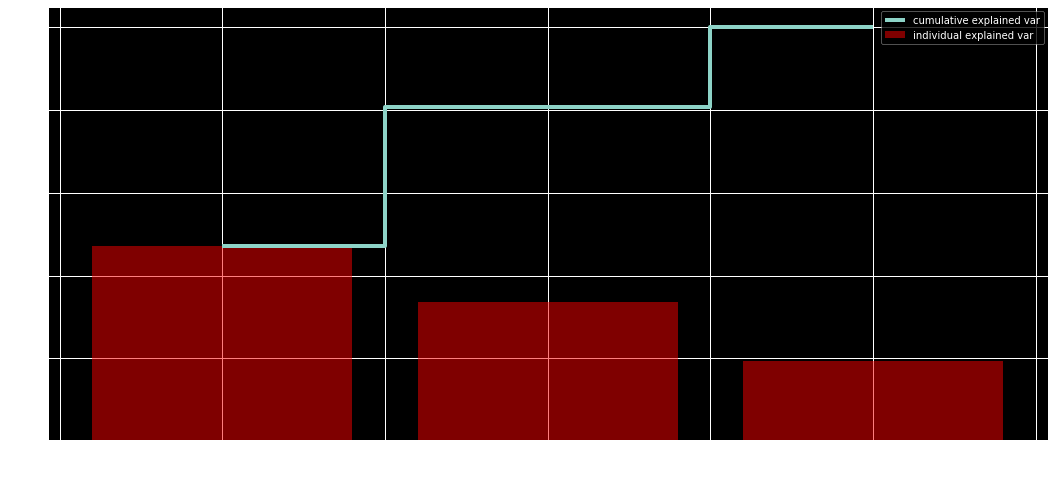

In [32]:
plt.figure(figsize = (16, 8))
plt.bar(range(len(var_exp)), var_exp, 
        alpha = 0.5, align = 'center', 
        label = 'individual explained var', 
        color = 'r'
       )

plt.step(range(len(cum_var_exp)), cum_var_exp,
         where = 'mid',
         label = 'cumulative explained var')

plt.xlabel('principal components')
plt.ylabel('explained var ratio')
plt.legend(loc = 'best')
plt.show();

Component 1 explains approx 50% of var. 
2 = explains < 40
3 = explains < 20 

Components 1 + 2 = explain approx 80% of var 

- set n_components = 2
- standardize features 

In [33]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

# Standardize features
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)

# Reduce components to 2 
pca = PCA(n_components = 2)
data = pca.fit_transform(data)

# Standardize 2 new features 
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [34]:
kmeans = [KMeans(n_clusters = i).fit(data) for i in n_cluster]

df['cluster'] = kmeans[7].predict(data)
df.index = data.index

df['pc1'] = data[0]
df['pc2'] = data[1]
df['cluster'].value_counts()

5    837
6    704
3    447
0    398
1    341
7    156
2     97
4     68
Name: cluster, dtype: int64

In [35]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [36]:
outliers_fraction = 0.01

distance = getDistanceByPoint(data, kmeans[9])
outlier_num = int(outliers_fraction * len(distance))

threshold = distance.nlargest(outlier_num).min()

df['anomaly'] = (distance >= threshold).astype(int)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


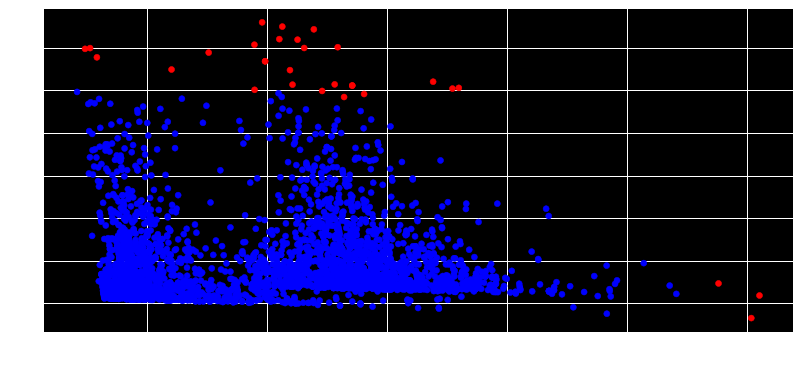

In [37]:
fig, ax = plt.subplots(figsize = (12, 6))

colors = {0:'blue', 1:'red'}

ax.scatter(df['pc1'], df['pc2'], 
           c = df['anomaly'].apply(lambda x: colors[x]))

plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show();

In [38]:
df = df.sort_values('date_time')
df['date_time'] = df.date_time.astype(np.int64)

# object with anomalies
a = df.loc[df['anomaly'] == 1, 
           ['date_time_int', 'price_usd']]

a

,date_time_int,price_usd
8,1351779652000000000,211.00
96,1352380267000000000,230.00
102,1352416996000000000,225.00
203,1353254473000000000,116.00
416,1354869170000000000,126.00
1005,1358444151000000000,102.00
1140,1359377578000000000,87.00
1157,1359523443000000000,112.00
1278,1360489270000000000,58.00
1441,1361549975000000000,122.00


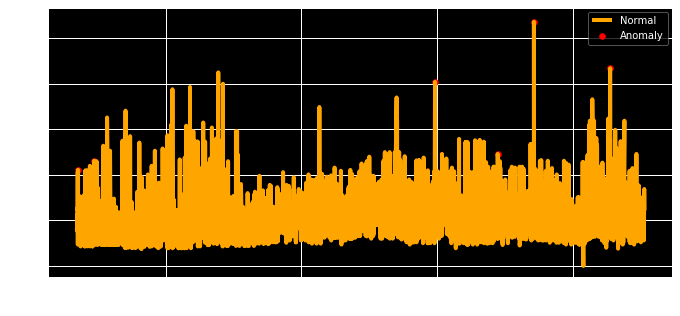

In [39]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(df['date_time_int'], df['price_usd'], 
        color = 'orange', label = 'Normal')

ax.scatter(a['date_time_int'], a['price_usd'],
           color = 'red', label = 'Anomaly')

plt.xlabel('time')
plt.ylabel('USD')
plt.legend()
plt.show();


In [40]:
df['anomaly'].unique()

array([0, 1])

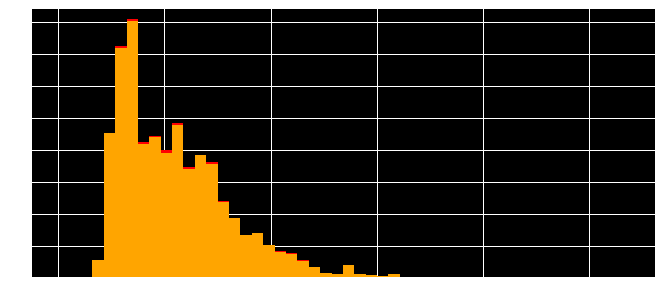

In [41]:
a = df.loc[df['anomaly'] == 0, 'price_usd']
b = df.loc[df['anomaly'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize = (10, 5))
axs.hist([a, b], 
         bins = 50, stacked = True, 
         color = ['orange', 'red'])

plt.show();

In [42]:
df.anomaly.value_counts()

0    3018
1      30
Name: anomaly, dtype: int64

In [43]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,date_time_int,cluster,pc1,pc2,anomaly
0,1351738110000000000,84.0,19,0,1351738110000000000,5,-0.889864,-0.521900,0
1,1351739203000000000,78.0,16,1,1351739203000000000,6,0.230566,-0.272218,0
2,1351760658000000000,114.0,56,1,1351760658000000000,0,0.567439,0.546642,0
3,1351761063000000000,76.0,56,1,1351761063000000000,0,0.155659,0.581776,0
4,1351764925000000000,128.0,0,1,1351764925000000000,6,0.793675,-0.659305,0


# Isolation Forest

Detect anomalies based on data points that are few and different 

- No use of density / distance measure 
    i.e. different from clustering based / distanced based algorithms 

- Randomly select a feature 
    
- Randomly select a split between max and min values of selected feature 
    
- Length of path, avged over a forest of random trees = measure of normality 

- Random partitioning = shorter path for anomalies

- If forest produces shorter paths for samples, then they are likely to be anomalies 

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


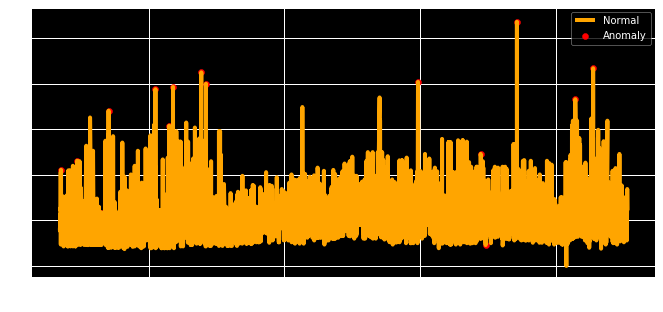

In [44]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)

data = pd.DataFrame(np_scaled)

# Isolation forest 
outliers_fraction = 0.01
ifo = IsolationForest(contamination = outliers_fraction)

ifo.fit(data)

df['anomaly1'] = pd.Series(ifo.predict(data))

fig, ax = plt.subplots(figsize = (10, 5))

a = df.loc[df['anomaly1'] == -1, ['date_time_int', 'price_usd']]

ax.plot(df['date_time_int'], df['price_usd'], 
        color = 'orange', label = 'Normal')

ax.scatter(a['date_time_int'], a['price_usd'], 
           color = 'red', label = 'Anomaly')

plt.legend()
plt.show();

In [45]:
df['anomaly1'].unique()

array([ 1, -1])

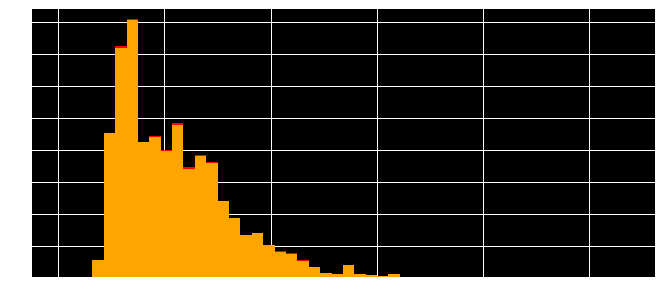

In [46]:
a = df.loc[df['anomaly1'] == 1, 'price_usd']
b = df.loc[df['anomaly1'] == -1, 'price_usd']

fig, ax = plt.subplots(figsize = (10, 5))

ax.hist([a, b],
        bins = 50, stacked = True, 
        color = ['orange', 'red'] )

plt.show();

In [47]:
df['anomaly1'].value_counts()

 1    3017
-1      31
Name: anomaly1, dtype: int64

# Support vector machine models

Associated with supervised learning 

- One class SVM
- Gaussian dist 
- Markov chain

# One class SVM 
- unsupervised anomaly detection 
- estimate support of high dimensional distribution

In [48]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)

data = pd.DataFrame(np_scaled)

# Train 

osvm = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)

osvm.fit(data)

df['anomaly2'] = pd.Series(osvm.predict(data))

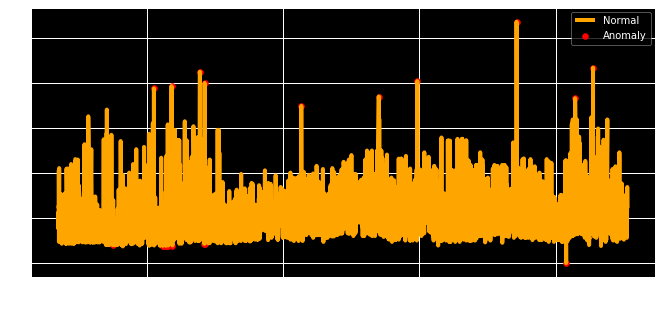

In [49]:
fig, ax = plt.subplots(figsize = (10, 5))

a = df.loc[df['anomaly2'] == -1, 
           ['date_time_int', 'price_usd']]

ax.plot(df['date_time_int'], df['price_usd'], 
        color = 'orange', 
        label = 'Normal')

ax.scatter(a['date_time_int'], a['price_usd'], 
           color = 'red', 
           label = 'Anomaly')

plt.legend()
plt.show();

In [50]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,date_time_int,cluster,pc1,pc2,anomaly,anomaly1,anomaly2
0,1351738110000000000,84.0,19,0,1351738110000000000,5,-0.889864,-0.521900,0,1,1
1,1351739203000000000,78.0,16,1,1351739203000000000,6,0.230566,-0.272218,0,1,1
2,1351760658000000000,114.0,56,1,1351760658000000000,0,0.567439,0.546642,0,1,1
3,1351761063000000000,76.0,56,1,1351761063000000000,0,0.155659,0.581776,0,1,1
4,1351764925000000000,128.0,0,1,1351764925000000000,6,0.793675,-0.659305,0,1,1


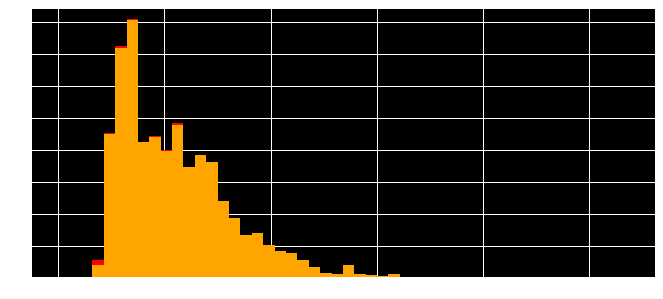

In [51]:
a = df.loc[df['anomaly2'] == 1, 'price_usd']
b = df.loc[df['anomaly2'] == -1, 'price_usd']

fig, ax = plt.subplots(figsize = (10, 5))

ax.hist([a, b], bins = 50, 
        stacked = True, color = ['orange','red'])

plt.show();

In [52]:
df['anomaly2'].value_counts()

 1    3017
-1      31
Name: anomaly2, dtype: int64

# Gaussian distribution

- Assume data is normally distributed

- Use covariance.EllipticEnvelope from scikit-learn to find key params of general distribution by assuming entire dataset = an expression of an underlying multivariate Gaussian distribution


Create two dfs based on categories defined by sat boolean

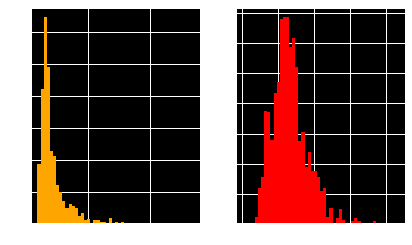

In [53]:
df_class0 = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
df_class1 = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

fig, axs = plt.subplots(1, 2)

df_class0.hist(ax = axs[0], bins = 50, color = 'orange')
df_class1.hist(ax = axs[1], bins = 50, color = 'red');

Apply EllipticEnvelope to each category 

Set contamination param (proportion of outliers present in dataset)

Use decision function to compute decision function of given observations (equivalent to shifted Mahalanobis distances. 

Threshold for identifying as outliers = 0 (compatible with other detection algorithms)

predict(x_train) predict labels of X_train according to fitted model

1 = normal
-1 = anomaly

In [54]:
envelope = EllipticEnvelope(contamination = outliers_fraction)

x_train = df_class0.values.reshape(-1, 1)
envelope.fit(x_train)

df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(x_train)
df_class0['anomaly'] = envelope.predict(x_train)

In [55]:
envelope = EllipticEnvelope(contamination = outliers_fraction)

x_train = df_class1.values.reshape(-1, 1)
envelope.fit(x_train)

df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(x_train)
df_class1['anomaly'] = envelope.predict(x_train)

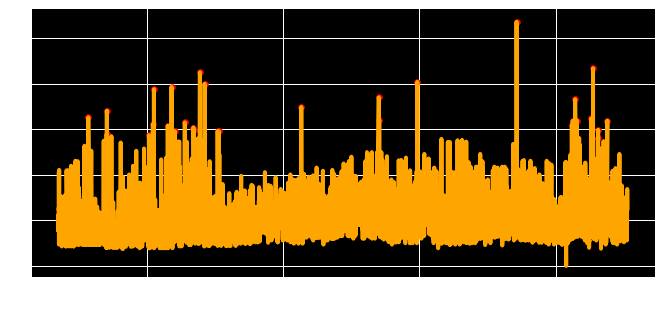

In [56]:
df_class = pd.concat([df_class0, df_class1])
df['anomaly3'] = df_class['anomaly']

fig, ax = plt.subplots(figsize = (10, 5))

a = df.loc[df['anomaly3'] == -1, 
           ('date_time_int', 'price_usd')]

ax.plot(df['date_time_int'], df['price_usd'], 
        color = 'orange')

ax.scatter(a['date_time_int'], a['price_usd'],
          color = 'red')

plt.show();

In [57]:
df['anomaly3'].value_counts()

 1    3017
-1      31
Name: anomaly3, dtype: int64

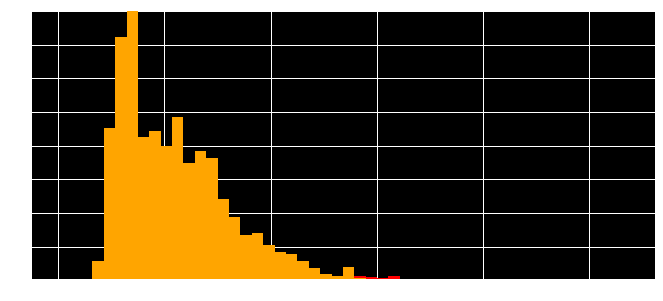

In [58]:
a = df.loc[df['anomaly3'] == 1, 'price_usd']
b = df.loc[df['anomaly3'] == -1, 'price_usd']

fig, ax = plt.subplots(figsize = (10, 5))
ax.hist([a, b], 
        bins = 50, stacked = True, 
        color = ['orange', 'red'])

plt.show();

# Results 
anomalies detected only show abnormally high prices, no abnormally low prices 